# My Neural Network

In [ ]:
import torch
import torch.nn as nn
import fastai.vision.all as fv
import math

In [ ]:
import torch
torch.cuda.is_available()

True

## Loading data

In [ ]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=True,
                            max_rotate=360,
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.2)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

Funcion para cargar las imágenes y regresarlas en batches

In [ ]:
#!unzip "/storage/animals2.zip"

In [ ]:
birds = load_data("/storage/birds", img_size=128, batch_size=64)

carga las imágenes que el modelo va a usar y lo guarda en batches

#### Convolucional

In [ ]:
##Flatten es una capa que ayuda a pasar de la parte convolucional a la parte lineal

#Lo que hace la clase es que le pasamos algo y nos regresa eso mismo pero sin los 1
class Flatten(nn.Module):   #Creamos un módulo que hereda de nn.Module
    def __init__(self):    #Para crear un objeto
        super().__init__() #Le decimos a nn.Module que se inicie
    
    def forward( self, x ): #
        #return x.squeeze()
        return x.reshape (x.shape[0],-1) #Toma la primera y adivina el resto
        #Se agrega esta porque si el batch es de tam 1, squezze lo elimina
        
#--Para tener idea de qué tan grande es nuestro modelo--#
def num_params(model):
    total = 0
    for p in model.parameters():
        num = 1
        for s in list(p.size()):
            num *= s
            total += num
    return total

Esta capa servirá para conectar las convolucionales con las lineales (densas)

#### ResBlock

In [ ]:
class ResBlock(nn.Module):
    def __init__( self, residual ): #residual -> f
        super().__init__()
        self.residual =  residual
        
    def forward (self, x):
        return x + self.residual(x) #Del mismo tamaño

In [ ]:
def crear_residual (filters): #Num filtros de x
    bottleneck = (filters+1)//2
    
    residual = nn.Sequential(
        #"Comprimimos la info"
        nn.Conv2d (filters, bottleneck, kernel_size=1),
        nn.ReLU(),
        nn.BatchNorm2d(bottleneck),
        #"Conv sobre los datos comprimidos"
        nn.Conv2d (bottleneck, bottleneck, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d (bottleneck),
        #"Descomprimimos los datos"
        nn.Conv2d (bottleneck, filters, kernel_size=1),
        nn.ReLU(),
        #Es importante SIEMPRE acabar en BatchNorm
        nn.BatchNorm2d(filters)
    )
    nn.init.constant_(residual[-1].weight,0) #Incialiar el último módulo de residual como 0
    return residual

Con Resblock cada capa calcula un residuo que dice cuánto va a sumarle a la entrada para prodicr una buena salida

### Red Convolucional hecha a mano

In [ ]:
data = birds

Veamos cómo quedaron las imágenes en los batches

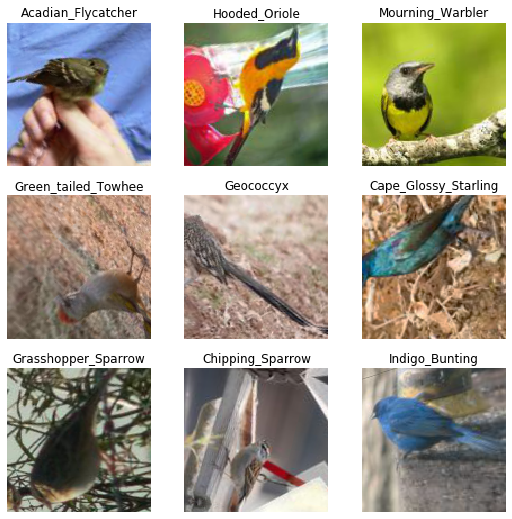

In [ ]:
data.show_batch()

No se ven buenos resultados si los giramos verticalmemte, así que haremso que estén 'derecahs las imágenes'

In [ ]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=False,
                            max_rotate=10,
                            max_lighting=0.25,
                            max_zoom=1.2,
                            max_warp=0.2)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

birds = load_data("/storage/birds", img_size=128, batch_size=64)

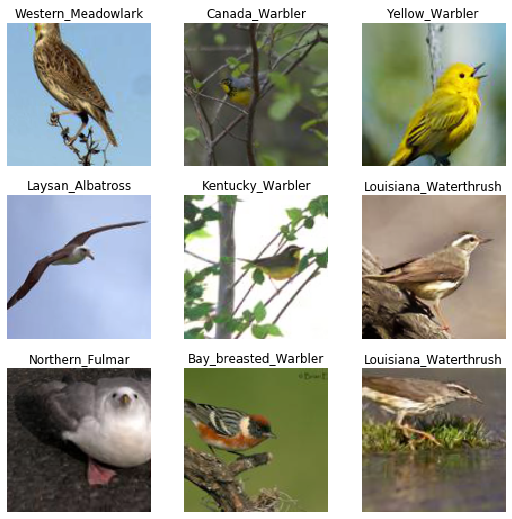

In [ ]:
birds.show_batch()

Las imágenes ya se ven bien

In [ ]:
data = birds

In [ ]:
lx97  = nn.Sequential( #Sequential para cosas sencillas
    nn.BatchNorm2d( 3 ), #Ideal comenzar normalizando 
    #Convolucion de entrada 3, de 32 filtros, de tamaño 3x3, 
    #sride -> ¿cuánto brinca?, padding -> pone el brde negro para no perder pixeles
    nn.Conv2d( 3, 32, kernel_size = 3, stride = 2, padding = 1),
    
    #Acivacion
    nn.ReLU(),
    ##ResBlock( crear_residual( 16 ) ),
    #Reducir el tamaño de a  imagen (será más rápido)
    #Cada cuadro de 2x2 agarra el más grande.
    #Reduce a la mitad
    #nn.MaxPool2d(2),
    #nn.Conv2d( 16, 32, kernel_size=2 ),
    #nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    nn.Conv2d( 32, 32, kernel_size=2, stride = 1, padding = 1 ),
    nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    
    #Empezamos en la cantidad de filtros con los que acabamos en Conv2d anterior
    nn.Conv2d( 32, 64, kernel_size = 2, stride = 1, padding = 1),
    
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 64, 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d( 128 ),
    nn.MaxPool2d(2),
    nn.Conv2d( 128, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    nn.Conv2d( 256, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 256, 512, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 512 ),
    nn.ReLU(),
    #--Aquí acabamos con la parte convolucional--#
    
    #--Llegamos a la parte lineal--#
    
    nn.AdaptiveAvgPool2d(1), #Reducir el tamaño a 1x1xn_canales
    #Podemos usar diferentes métodos para llegar a 1x1
    Flatten(), #Usamos la funcion que habiamos creado pra eliminar las de dim 1
    #Los quita para poder usar Linear
    nn.Linear( 512, 256), #Completamente conectada
    nn.ReLU(),
    nn.Linear( 256, data.c) #salida con el total de clases de los datos
)

In [ ]:
lx97

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): ReLU()
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1

In [ ]:
num_params(lx97)

3299318

## Entrenando el modelo

In [ ]:
learn_birds = fv.Learner( data, lx97, metrics=fv.accuracy)#.to_fp16()

In [ ]:
learn_birds.summary()

Sequential (Input shape: ['64 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm2d          64 x 3 x 128 x 128   6          True      
________________________________________________________________
Conv2d               64 x 32 x 64 x 64    896        True      
________________________________________________________________
ReLU                 64 x 32 x 64 x 64    0          False     
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 64    64         True      
________________________________________________________________
Conv2d               64 x 32 x 65 x 65    4,128      True      
________________________________________________________________
ReLU                 64 x 32 x 65 x 65    0          False     
________________________________________________________________
BatchNorm2d          64 x 32 x 65 x 65    64         True      
_________________________________________________

## Model train (birds)

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=3.311311274956097e-06)

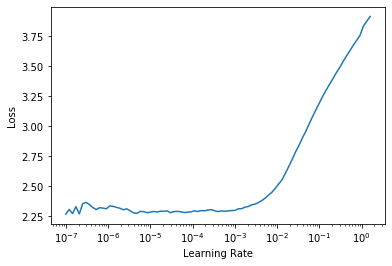

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(35,2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.300364,3.078704,0.270625,00:16
1,2.347345,3.166815,0.267691,00:16
2,2.406883,3.244747,0.247843,00:16
3,2.497694,3.320010,0.226614,00:16
4,2.608469,3.595324,0.203659,00:16
5,2.731075,3.456022,0.201760,00:16
6,2.774950,3.795385,0.176907,00:16
7,2.791786,3.808702,0.181395,00:16
8,2.743112,3.844580,0.176907,00:16
9,2.707566,3.766855,0.193821,00:16


Entrené con lr diferentes empecé con accuracys de 0.004 y llegué hasta alrededor de .33, pero con diferentes train_loss y valid_loss.

In [ ]:
learn_birds.save("Birds_33")

Path('models/Birds_33.pth')

In [ ]:
learn_birds.load("Birds_27")

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=5.248074739938602e-05)

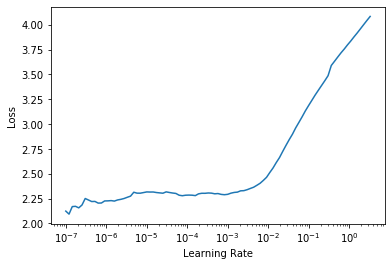

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(35,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.266030,3.087565,0.270107,00:16
1,2.292455,3.073752,0.270970,00:16
2,2.288130,3.095871,0.272523,00:16
3,2.262235,3.074543,0.273214,00:16
4,2.298934,3.058146,0.275975,00:16
5,2.318038,3.119711,0.272006,00:16
6,2.286478,3.096495,0.271488,00:16
7,2.292422,3.077089,0.274249,00:17
8,2.284046,3.099349,0.272696,00:16
9,2.274200,3.074246,0.279427,00:16


In [ ]:
learn_birds.fit_one_cycle(35,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.038403,3.011243,0.297377,00:16
1,2.043587,3.099588,0.286158,00:16
2,2.090208,3.093369,0.284260,00:16
3,2.160985,3.139683,0.281498,00:16
4,2.245000,3.212582,0.261477,00:16
5,2.312621,3.397726,0.249396,00:16
6,2.352435,3.730006,0.213842,00:16
7,2.366891,3.498982,0.231792,00:16
8,2.357178,3.375194,0.244563,00:16
9,2.314790,3.242551,0.266483,00:16


Aquí se ve que está sobreajustado

In [ ]:
lx97  = nn.Sequential( #Sequential para cosas sencillas
    nn.BatchNorm2d( 3 ), #Ideal comenzar normalizando 
    #Convolucion de entrada 3, de 32 filtros, de tamaño 3x3, 
    #sride -> ¿cuánto brinca?, padding -> pone el brde negro para no perder pixeles
    nn.Conv2d( 3, 32, kernel_size = 3, stride = 2, padding = 1),
    
    #Acivacion
    nn.ReLU(),
    ##ResBlock( crear_residual( 16 ) ),
    #Reducir el tamaño de a  imagen (será más rápido)
    #Cada cuadro de 2x2 agarra el más grande.
    #Reduce a la mitad
    #nn.MaxPool2d(2),
    #nn.Conv2d( 16, 32, kernel_size=2 ),
    #nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    nn.Conv2d( 32, 32, kernel_size=2, stride = 1, padding = 1 ),
    nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    
    #Empezamos en la cantidad de filtros con los que acabamos en Conv2d anterior
    nn.Conv2d( 32, 64, kernel_size = 2, stride = 1, padding = 1),
    
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d( 64, 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d( 128 ),
    nn.MaxPool2d(2),
    nn.Conv2d( 128, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    nn.Conv2d( 256, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    #nn.MaxPool2d(2),
    nn.Conv2d( 256, 512, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 512 ),
    nn.ReLU(),
    #--Aquí acabamos con la parte convolucional--#
    
    #--Llegamos a la parte lineal--#
    
    nn.AdaptiveAvgPool2d(1), #Reducir el tamaño a 1x1xn_canales
    #Podemos usar diferentes métodos para llegar a 1x1
    Flatten(), #Usamos la funcion que habiamos creado pra eliminar las de dim 1
    #Los quita para poder usar Linear
    #nn.Linear( 512, 256), #Completamente conectada
    #nn.ReLU(),
    nn.Linear( 512, data.c) #salida con el total de clases de los datos
)

Sólo paso una vez por Linear

In [ ]:
learn_birds = fv.Learner( data, lx97, metrics=fv.accuracy)#.to_fp16()

In [ ]:
learn_birds.summary()

Sequential (Input shape: ['64 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm2d          64 x 3 x 128 x 128   6          True      
________________________________________________________________
Conv2d               64 x 32 x 64 x 64    896        True      
________________________________________________________________
ReLU                 64 x 32 x 64 x 64    0          False     
________________________________________________________________
BatchNorm2d          64 x 32 x 64 x 64    64         True      
________________________________________________________________
Conv2d               64 x 32 x 65 x 65    4,128      True      
________________________________________________________________
ReLU                 64 x 32 x 65 x 65    0          False     
________________________________________________________________
BatchNorm2d          64 x 32 x 65 x 65    64         True      
_________________________________________________

SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=1.0964781722577754e-06)

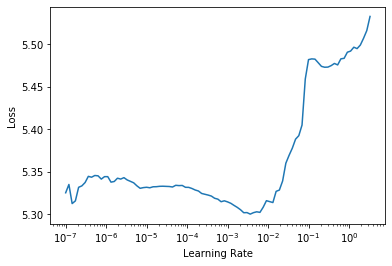

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(40,0.000363)

epoch,train_loss,valid_loss,accuracy,time
0,5.281010,5.234844,0.007421,00:18
1,5.163864,5.098905,0.021747,00:18
2,5.039620,4.975945,0.030721,00:18
3,4.910519,4.854931,0.034691,00:18
4,4.786681,4.757650,0.040214,00:18
5,4.664581,4.637288,0.050915,00:18
6,4.563286,4.550530,0.057473,00:18
7,4.463907,4.481733,0.064377,00:18
8,4.368849,4.443874,0.068347,00:18
9,4.275654,4.321831,0.075768,00:18


Había leído que es mejor entrenar pocas veces, pero con diferentes lr

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=1.5848931980144698e-06)

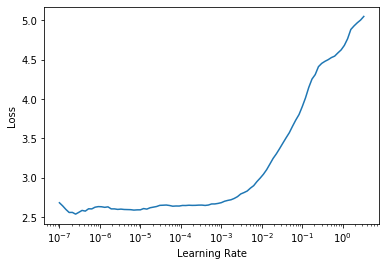

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(15,1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.645608,3.328959,0.222126,00:19
1,2.641220,3.332180,0.222817,00:18
2,2.655880,3.325263,0.223852,00:18
3,2.641876,3.331428,0.222817,00:18
4,2.649111,3.316011,0.224370,00:18
5,2.665767,3.315845,0.222644,00:18
6,2.636275,3.342478,0.220400,00:18
7,2.650530,3.314473,0.225578,00:18
8,2.660736,3.336464,0.222817,00:18
9,2.634117,3.308327,0.226269,00:18


Algo está mal con el lr porque no varió

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=3.311311274956097e-06)

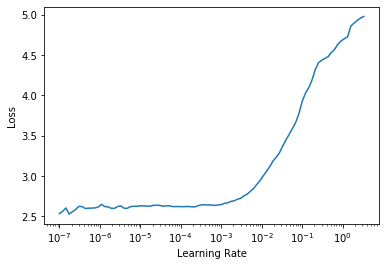

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(15,1e-2)

In [ ]:
learn_birds.save("NoseAccuracy")

Path('models/NoseAccuracy.pth')

### Ya probamos un par de modelos, pero vamos a modificarlos más a fondo

In [ ]:
lx97  = nn.Sequential( #Sequential para cosas sencillas
    nn.BatchNorm2d( 3 ), #Ideal comenzar normalizando 
    #Convolucion de entrada 3, de 32 filtros, de tamaño 3x3, 
    #sride -> ¿cuánto brinca?, padding -> pone el brde negro para no perder pixeles
    nn.Conv2d( 3, 32, kernel_size = 3, stride = 2, padding = 1),
    
    #Acivacion
    nn.ReLU(),
    ##ResBlock( crear_residual( 16 ) ),
    #Reducir el tamaño de a  imagen (será más rápido)
    #Cada cuadro de 2x2 agarra el más grande.
    #Reduce a la mitad
    nn.MaxPool2d(2),
    #nn.Conv2d( 16, 32, kernel_size=2 ),
    #nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    nn.Conv2d( 32, 32, kernel_size=2, stride = 1, padding = 1 ),
    nn.ReLU(),
    nn.BatchNorm2d( 32 ),
    
    #Empezamos en la cantidad de filtros con los que acabamos en Conv2d anterior
    nn.Conv2d( 32, 64, kernel_size = 2, stride = 1, padding = 1),
    
    nn.ReLU(),
    #nn.MaxPool2d(2),
    nn.Conv2d( 64, 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d( 128 ),
    #nn.MaxPool2d(2),
    nn.Conv2d( 128, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    nn.Conv2d( 256, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    #nn.MaxPool2d(2),
    nn.Conv2d( 256, 512, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 512 ),
    nn.ReLU(),
    #--Aquí acabamos con la parte convolucional--#
    
    #--Llegamos a la parte lineal--#
    
    nn.AdaptiveAvgPool2d(1), #Reducir el tamaño a 1x1xn_canales
    #Podemos usar diferentes métodos para llegar a 1x1
    Flatten(), #Usamos la funcion que habiamos creado pra eliminar las de dim 1
    #Los quita para poder usar Linear
    #nn.Linear( 512, 256), #Completamente conectada
    #nn.ReLU(),
    nn.Linear( 512, data.c) #salida con el total de clases de los datos
)

Quitamos los Maxpool

#### Ahora entrenamos

In [ ]:
birds = load_data("/storage/birds", img_size=128, batch_size=128)

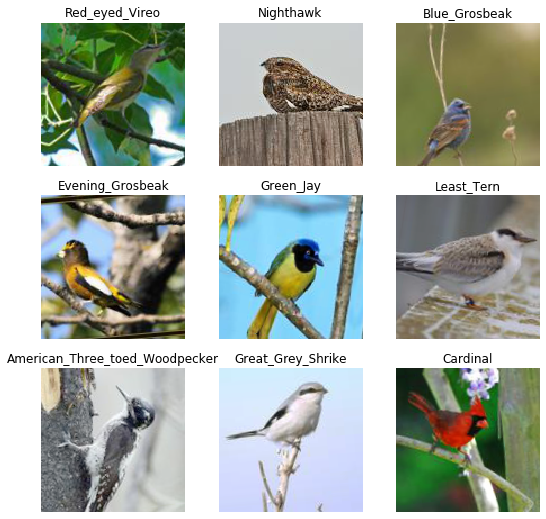

In [ ]:
birds.show_batch()

Se ve que algunas imagenes tienen zoom de más, pues parecen cortadas. Vamos aaplicar más transformaciones

In [ ]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=False,
                            max_rotate=10,
                            max_lighting=0.25,
                            max_zoom=.9,
                            max_warp=0)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

birds = load_data("/storage/birds", img_size=128, batch_size=64)

Esa fue la mayor combinación de img_size y batch_size que pude tenre sin acabarme la memoria

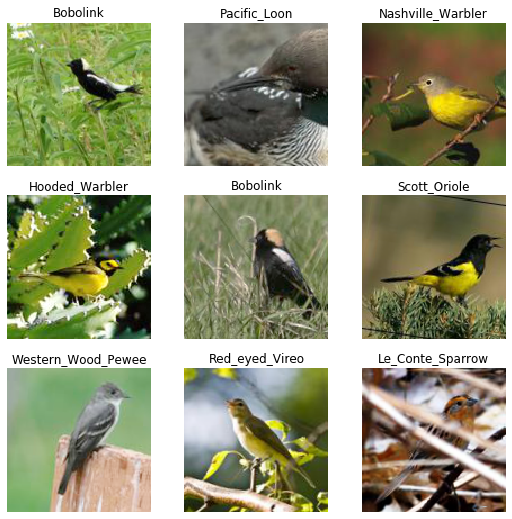

In [ ]:
birds.show_batch()

In [ ]:
learn_birds = fv.Learner( birds, lx97, metrics=fv.accuracy).to_fp16()

Lo pasamos a fp16 para crear batches más grandes. Ahora el batch_size es del doble de tamaño que en lo modelos anteriores

In [ ]:
num_params(lx97)

3218934

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.9120108485221863)

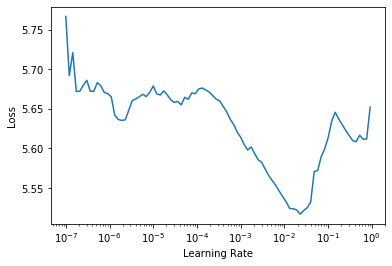

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.409333,5.342910,0.012081,00:33
1,5.230413,5.137672,0.015016,00:33
2,5.061519,5.062462,0.022955,00:33
3,4.870506,4.859115,0.036762,00:33
4,4.693449,4.696886,0.036417,00:33
5,4.518498,4.580371,0.058509,00:33
6,4.348702,4.385313,0.070763,00:33
7,4.221195,4.308686,0.081464,00:33
8,4.132663,4.277007,0.084570,00:33
9,4.092261,4.273160,0.085606,00:33


Mis tiempos de entranamiento son muy tardados en relación a los anteriores que he tenido. Tengo la intuición de que es por el problema con PAPERSPACE

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.5248074531555176)

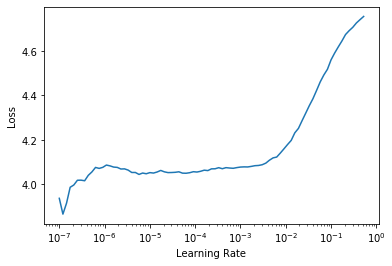

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(15,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.305390,5.320557,0.004833,00:33
1,5.298313,5.282493,0.007939,00:33
2,5.264868,5.351935,0.010010,00:33
3,5.246983,5.237066,0.011391,00:33
4,5.222280,5.214943,0.011391,00:33
5,5.211647,5.214222,0.013635,00:33
6,5.177991,5.167147,0.016396,00:33
7,5.150941,5.154225,0.019158,00:33
8,5.134858,5.142972,0.021919,00:33
9,5.115569,5.135990,0.019158,00:33


In [ ]:
#learn_birds.load("Birds_33")

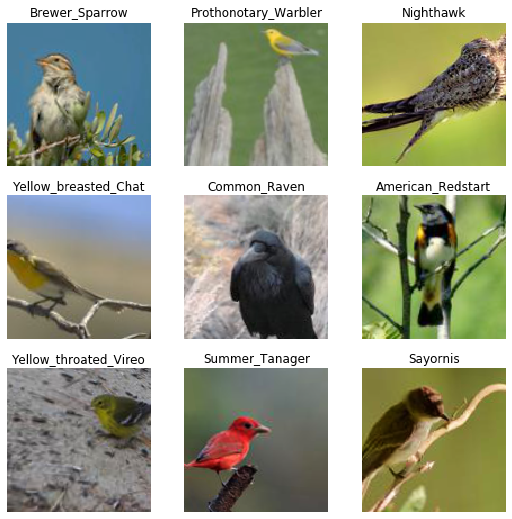

In [ ]:
birds.show_batch()

In [ ]:
lx97  = nn.Sequential( #Sequential para cosas sencillas
    nn.BatchNorm2d( 3 ), #Ideal comenzar normalizando 
    #Convolucion de entrada 3, de 32 filtros, de tamaño 3x3, 
    #sride -> ¿cuánto brinca?, padding -> pone el brde negro para no perder pixeles
    nn.Conv2d( 3, 32, kernel_size = 3, stride = 2, padding = 1),
    
    #Acivacion
    nn.ReLU(),
    ##ResBlock( crear_residual( 16 ) ),
    #Reducir el tamaño de a  imagen (será más rápido)
    #Cada cuadro de 2x2 agarra el más grande.
    #Reduce a la mitad
    nn.MaxPool2d(2),
    #nn.Conv2d( 16, 32, kernel_size=2 ),
    #nn.ReLU(),
    #nn.BatchNorm2d( 32 ),
    nn.Conv2d( 32, 32, kernel_size=2, stride = 1, padding = 1 ),
    nn.ReLU(),
    #nn.BatchNorm2d( 32 ),
    
    #Empezamos en la cantidad de filtros con los que acabamos en Conv2d anterior
    nn.Conv2d( 32, 64, kernel_size = 2, stride = 1, padding = 1),
    
    nn.ReLU(),
    #nn.MaxPool2d(2),
    nn.Conv2d( 64, 128, kernel_size = 3, stride = 1, padding = 1),
    nn.ReLU(),
    nn.BatchNorm2d( 128 ),
    #nn.MaxPool2d(2),
    nn.Conv2d( 128, 256, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 256 ),
    nn.ReLU(),
    #nn.Conv2d( 256, 256, kernel_size = 3, stride = 1, padding = 1),
    #nn.BatchNorm2d( 256 ),
    #nn.ReLU(),
    #nn.MaxPool2d(2),
    nn.Conv2d( 256, 512, kernel_size = 3, stride = 1, padding = 1),
    nn.BatchNorm2d( 512 ),
    nn.ReLU(),
    #--Aquí acabamos con la parte convolucional--#
    
    #--Llegamos a la parte lineal--#
    
    nn.AdaptiveAvgPool2d(1), #Reducir el tamaño a 1x1xn_canales
    #Podemos usar diferentes métodos para llegar a 1x1
    Flatten(), #Usamos la funcion que habiamos creado pra eliminar las de dim 1
    #Los quita para poder usar Linear
    nn.Linear( 512, 256), #Completamente conectada
    nn.ReLU(),
    nn.Linear( 256, birds.c) #salida con el total de clases de los datos
)

In [ ]:
num_params(lx97)

2446198

In [ ]:
learn_birds = fv.Learner( birds, lx97, metrics=fv.accuracy).to_fp16()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

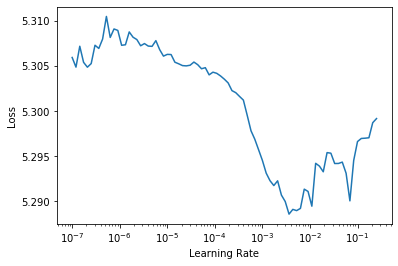

In [ ]:
learn_birds.lr_find()

In [ ]:
learn_birds.fit_one_cycle(25, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.294584,5.306266,0.005350,00:26
1,5.257290,5.197052,0.013980,00:25
2,5.175834,5.082029,0.015533,00:25
3,5.077237,5.007287,0.020193,00:25
4,4.979026,4.943273,0.023473,00:24
5,4.905145,4.916070,0.026061,00:25
6,4.817202,5.026211,0.029858,00:24
7,4.725466,4.835338,0.036072,00:24
8,4.637159,4.698897,0.033656,00:24
9,4.554986,4.675358,0.038315,00:25


In [ ]:
learn_birds.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.779578,4.090172,0.097515,00:24
1,3.802145,4.303893,0.074560,00:25
2,3.868245,4.421926,0.054712,00:24
3,3.902221,4.307018,0.072144,00:25
4,3.883435,4.236881,0.081636,00:25
5,3.872370,4.288060,0.076458,00:25
6,3.828410,4.359142,0.075941,00:24
7,3.769024,4.137172,0.096652,00:25
8,3.710244,4.048962,0.103555,00:25
9,3.647933,4.067448,0.102002,00:25


In [ ]:
learn_birds.save('learn_birds_final_parte2')

Path('models/learn_birds_final_parte2.pth')

# 3- Descarga otro de los datasets que le tocaron a tus compañeros, o usa el de las flores, (o ambas) para pre-entrenar el mismo modelo (pero desde 0) 

In [ ]:
def load_data(folder, img_size,batch_size):
    tmfs = fv.aug_transforms(flip_vert=False,
                            max_rotate=10,
                            max_lighting=0.25,
                            max_zoom=.9,
                            max_warp=0.2)
    data = fv.DataBlock(blocks  = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter  = fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms = fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms = tmfs)
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

In [ ]:
animalitos = load_data("/storage/AnimalsSmall/images", img_size=128, batch_size=64)

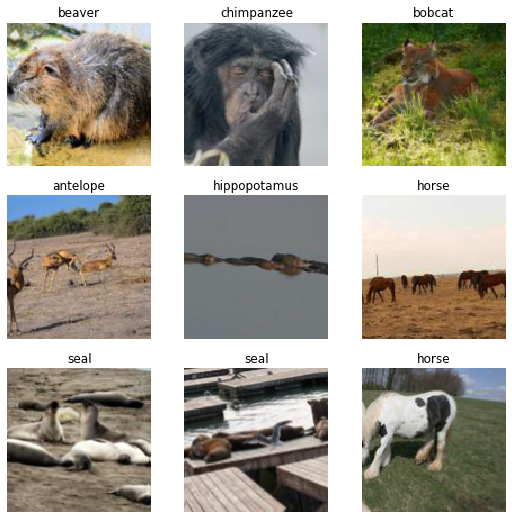

In [ ]:
animalitos.show_batch()

In [ ]:
lx97_1 = lx97

El mismo modelo, pero entrenando desde 0 en animales

In [ ]:
lx97_1[-1] = nn.Linear( 256, animalitos.c) #categorias de animals

In [ ]:
learn_animals = fv.Learner( animalitos, lx97_1, metrics=fv.accuracy).to_fp16()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

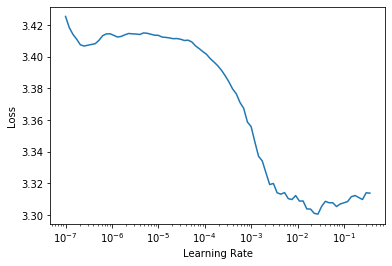

In [ ]:
learn_animals.lr_find()

In [ ]:
learn_animals.fit_one_cycle(25,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.116650,3.020564,0.155000,00:39
1,2.864253,2.764275,0.205000,00:37
2,2.641161,2.734479,0.232308,00:37
3,2.489018,2.536776,0.276538,00:38
4,2.355151,2.517844,0.268846,00:37
5,2.253722,2.798605,0.258077,00:37
6,2.183104,2.633399,0.281923,00:37
7,2.059416,2.312979,0.333077,00:37
8,1.980283,2.353836,0.334615,00:38
9,1.901824,2.283151,0.359231,00:37


In [ ]:
learn_animals.save('learn_animals_final_3')

Path('models/learn_animals_final_3.pth')

In [ ]:
learn_animals.load('learn_animals_final_3')

Notamos que el accuracy aumento demasiado en respecto a entrenarlo desde 0

# 4. Después, re-entrena SOLO las últimas capas en tu dataset original, y compara: ¿fue mejor pre-entrenar con otros datos, o no sirvió de nada?

In [ ]:
lx97_1[-1] = nn.Linear( 256, birds.c )

Regresamos la ultima capa a las categorias de aves

In [ ]:
learner_birds2 = fv.Learner(birds, lx97_1, metrics=fv.accuracy).to_fp16()

In [ ]:
learner_birds2.freeze_to(-1) # Congelamos todas las capas excepto la última

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=7.585775847473997e-07)

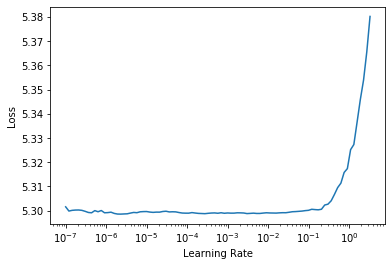

In [ ]:
learner_birds2.lr_find()

In [ ]:
learner_birds2.fit_one_cycle(25,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.380588,5.304973,0.008112,00:26
1,5.191111,5.052581,0.023818,00:26
2,4.840848,4.673656,0.047118,00:26
3,4.500752,4.431415,0.064032,00:26
4,4.241145,4.311914,0.068519,00:26
5,3.990820,4.017170,0.101829,00:26
6,3.787241,4.208185,0.102520,00:26
7,3.627887,3.848826,0.129099,00:26
8,3.465090,3.788142,0.142216,00:26
9,3.369585,3.724651,0.148257,00:26


Se nota que se tienen mejores resultados despues de pre-entrenar la red con un dataset diferente, en comparacion con solo hacerlo con el datasetobjetivo

# 5. Crea una Transform que se aplique aleatoriamente con probabilidad 1/10 que convierta a la imagen en blanco y negro (escala de grises).

Para hacer mi transforrmada segui la doc de:
- https://docs.fast.ai/tutorial.albumentations

In [ ]:
from fastai.vision.all import *
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

In [ ]:
to_tensor = ToTensor()
to_pil = ToPILImage()

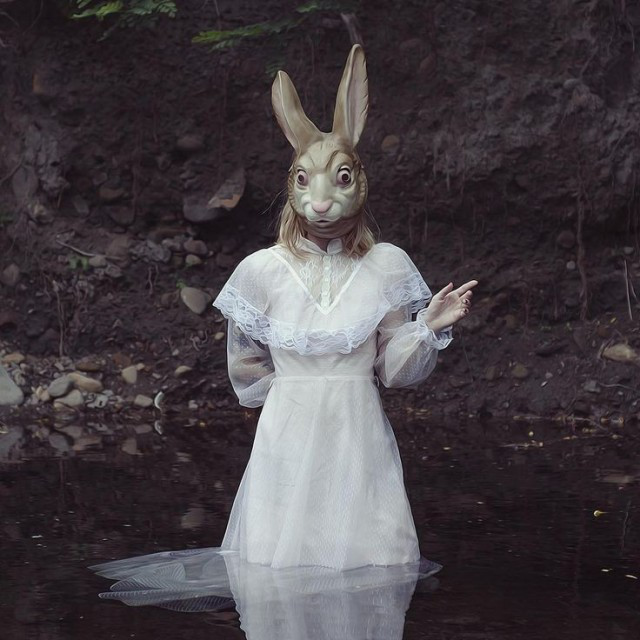

In [ ]:
img = Image.open('storage/dark_art.jpg')
img

In [ ]:
from torchvision.transforms.functional import to_grayscale as gray

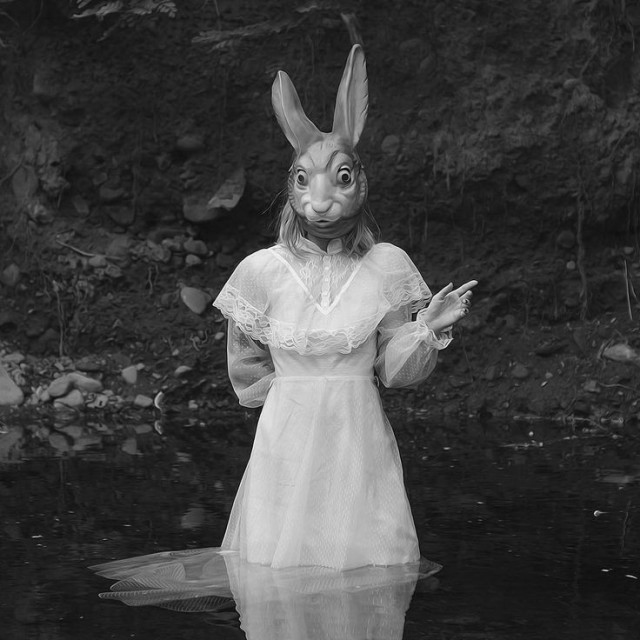

In [ ]:
gray(img)

In [ ]:
def img_to_gray1(img): 
    return gray(img)

Funcion para escala de grises

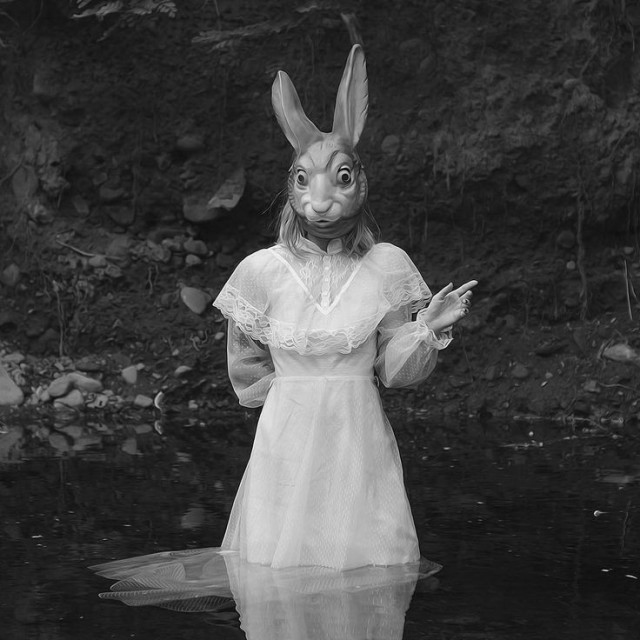

In [ ]:
img_to_gray1(img)

In [ ]:
class A_gris_1de10_1(fv.Transform):
    def __init__(self, img_to_gray1):
        self.img_to_gray1 = img_to_gray1
        
    def encodes(self, img: fv.TensorImage):
       
        grayscale = self.img_to_gray1(img)
        return (grayscale) #Return image

Creo la clase para pasar a escala de grises

In [ ]:
def load_data_gray_1(folder, img_size, batch_size):
    tmfs = fv.aug_transforms(flip_vert   =  False,
                            max_rotate   =  10,
                            max_lighting =  0.25,
                            max_zoom     =  .9,
                            max_warp     =  0,
                            xtra_tfms    =  A_gris_1de10_1(img_to_gray1)
                            )
    data = fv.DataBlock(blocks     =  (fv.ImageBlock, fv.CategoryBlock),
                        get_items  =  fv.get_image_files,
                        get_y      =  fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter   =  fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms  =  fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms =  tmfs)
                             
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

birds_gray = load_data_gray_1("/storage/birds", img_size=128, batch_size=64)

Could not do one pass in your dataloader, there is something wrong in it


In [ ]:
birds_gray.show_batch()

TypeError: img should be PIL Image. Got <class 'fastai.torch_core.TensorImage'>

Ya sale la imagen a blanco y negro, pero le falta que sea 1 de cada 10

Entonces le vamos a meter la probabilidad en la funcion. Si le toca la probabilidad de 1/10 que la convierta, sino nel

In [ ]:
#import numpy as np
#np.random.uniform(0,10,10)

#import random
#for i in range (10):
    #print(random.randint(1,10))

In [ ]:
def img_to_gray_probabilidad(img): 
    prob = random.randint(1,10)
    if prob == 7: #Mi num fav
        return gray(img)
        
    return (img_gray)


In [ ]:
class A_gris_1de10(fv.Transform):
    def __init__(self, img_to_gray_probabilidad):
        self.img_to_gray_probabilidad = img_to_gray_probabilidad
        
    def encodes(self, img: fv.TensorImage):
       
        grayscale = self.img_to_gray_probabilidad(img)
        return (grayscale) #Return image

In [ ]:
def load_data_gray(folder, img_size, batch_size):
    tmfs = fv.aug_transforms(flip_vert   =  False,
                            max_rotate   =  10,
                            max_lighting =  0.25,
                            max_zoom     =  .9,
                            max_warp     =  0,
                            xtra_tfms    =  A_gris_1de10(img_to_gray_probabilidad)
                            )
    data = fv.DataBlock(blocks     =  (fv.ImageBlock, fv.CategoryBlock),
                        get_items  =  fv.get_image_files,
                        get_y      =  fv.parent_label, #Como a partir de la imagen encpontarr la categoria
                        splitter   =  fv.GrandparentSplitter(), #si el abyelo es train o test
                        item_tfms  =  fv.Resize(img_size),#transformcaiones antes de juntar en batch y despues de juntar en batch)
                        batch_tfms =  tmfs)
                             
    return data.dataloaders(folder, bs=batch_size)#Agarra las imagenes y las regresa en batches

birds_gray = load_data_gray("/storage/birds", img_size=128, batch_size=64)

In [ ]:
birds_gray.show_batch()

TypeError: img should be PIL Image. Got <class 'fastai.torch_core.TensorImage'>

In [ ]:
def img_to_gray_probabilidad(img): 
    prob = random.randint(1,10)
    if prob == 7: #Mi num fav
        return gray(img)

In [ ]:
class A_gris_1de10(fv.Transform):
    def __init__(self, img_to_gray_probabilidad):
        self.img_to_gray_probabilidad = img_to_gray_probabilidad
        
    def encodes(self, img: fv.TensorImage):
       
        grayscale = self.img_to_gray_probabilidad(img)
        return (grayscale) #Return image